# Data API: OGC Coverages example

OGC Coverages is the replacement for Web Coverage Service. It is only a draft standard at the moment.

More info about the API can be found here - https://ogcapi.ogc.org/coverages/overview.html

### Using NOAA CRW degree heating week data as an example - this notebook demonstrates

- List available datasets (coverages)
- Get metadata for a coverage
- Get "domain set" for a coverage
- Get "range type" for a coverage
- Fetch single time step across entire spatial extent
  - as CoverageJSON
  - as zipped zarr dataset
- Fetch single point across time interval
  - as CoverageJSON
  - as zipped zarr dataset

### Notes on `owslib`

`owslib` is a python library for working with OGC web services and the new OGC APIs - it has incomplete support for OGC Coverages.

### Notes on CoverageJSON

- It is a new and immature format
- Not widely supported (no nice python wrapper for it yet)
- Basically it returns a flat JSON array with a bunch of metadata

In [2]:
# First, install and load the required packages.

import subprocess

packages = [
    'matplotlib',
    'numpy',
    'requests',
    'xarray',
    'zarr'
]

for package in packages:
    try:
        subprocess.check_call(['pip', 'install', package])
        print(f'Successfully installed {package}')
    except subprocess.CalledProcessError as e:
        print(f'Error occurred while installing {package}: {e}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.1/999.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.1/206.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.3 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=e366d8c2accade85d7d125069520022d258e0405fb078d75f5b5a08a1064b911
  Stored in directory: 

In [3]:
# Import packages and load environment

import os
from getpass import getpass

import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
import zarr
from IPython.display import JSON
from owslib.ogcapi.coverages import Coverages

# Connecting to Data API - OGC Coverages

We first connect to the Data API by setting up a OGC Coverages API endpoint.

To do this, you will need to go to https://dashboard.staging.reefdata.io/ and copy your Authentication token.
This can then be pasted into the password prompt.

In [4]:
token = getpass()
w = Coverages(f'https://pygeoapi.staging.reefdata.io', headers={'Authorization': f'Bearer {token}'})

## List available coverages

In [5]:
coverages = w.coverages()
coverages

['noaa-crw-dhw']

## Get coverage metadata

The following is equivalent to 

- https://pygeoapi.staging.reefdata.io/collections/noaa-crw-dhw

In [8]:
coverage = w.collection('noaa-crw-dhw')
JSON(coverage)

<IPython.core.display.JSON object>

## Get Coverage DomainSet

The domain set is the detailed n-dimensional space covered by the data. It is a list of axes, each with a name, a description, a range of values, and a reference system.

The following is equivalent to

- https://pygeoapi.staging.reefdata.io/collections/noaa-crw-dhw/coverage/domainset

In [9]:
coverage_domainset = w.coverage_domainset('noaa-crw-dhw')

JSON(coverage_domainset["generalGrid"])

<IPython.core.display.JSON object>

## Get Coverage RangeType

A `RangeType` describes the data values semantics (their components and data type)

The following is equivalent to

- https://pygeoapi.staging.reefdata.io/collections/noaa-crw-dhw/coverage/rangetype

In [10]:
coverage_rangetype = w.coverage_rangetype('noaa-crw-dhw')

JSON(coverage_rangetype)

<IPython.core.display.JSON object>

## Get CoverageJson

Get a single time slice of the data - at `2023-02-01`

- https://pygeoapi.staging.reefdata.io/collections/noaa-crw-dhw/coverage?datetime=2023-02-01

In [11]:
# owslib doesn't support all coverage parameters at this time
# test = w.coverage('016-023-noaa-crw', datetime="1985-04-03T00:00:00/1985-04-04T00:00:00")

# So we request the URL equivalent
url = f'https://pygeoapi.staging.reefdata.io/collections/noaa-crw-dhw/coverage?datetime=2023-02-01'

coverage_json = requests.get(url, headers={'Authorization': f'Bearer {token}'}).json()

## Print CoverageJSON parameters

In [12]:
JSON(coverage_json["parameters"])

<IPython.core.display.JSON object>

## Print CoverageJSON domain

In [13]:
JSON(coverage_json["domain"])

<IPython.core.display.JSON object>

## Plot the data!

This is a very basic example that just draws pixels on a grid.

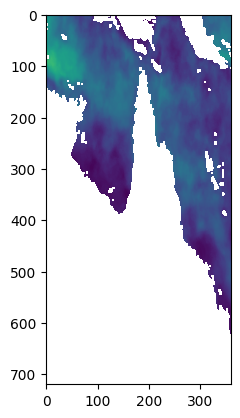

In [14]:
degree_heating_week = coverage_json["ranges"]["degree_heating_week"]
width = coverage_json["domain"]["axes"]["x"]["num"]
height = coverage_json["domain"]["axes"]["y"]["num"]

# Values is 1D array - so reshape into 2D
data = np.array(degree_heating_week["values"]).reshape(width, height).astype(float)

# Plot raster data
plt.imshow(data)
plt.show()

## Do a pixel drill

Get pixel values from `2013-01-01` to `2023-01-01` at single point `(-20.42, 155.5)`.

Note: currently this example uses the `subset` parameter to request a tiny bounding box around the point.

This is calling

- https://pygeoapi.staging.reefdata.io/collections/noaa-crw-dhw/coverage?datetime=2013-01-01/2023-01-01&subset=lon(155.52:155.54),lat(-20.43:-20.42)

In [15]:
url = f'https://pygeoapi.staging.reefdata.io/collections/noaa-crw-dhw/coverage?datetime=2013-01-01/2023-01-01&subset=lon(155.52:155.54),lat(-20.43:-20.42)'

coverage_json = requests.get(url, headers={'Authorization': f'Bearer {token}'}).json()

## Plot the (raw) data!

This is a very basic example that just draws line plot of the values.

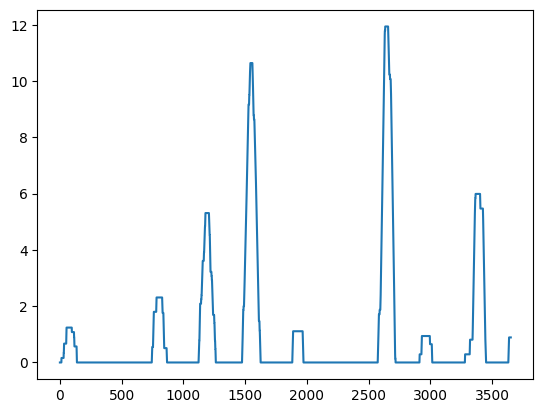

In [16]:
degree_heating_week = coverage_json["ranges"]["degree_heating_week"]

plt.plot(degree_heating_week["values"])

## Fetch zarr instead of CoverageJSON

CoverageJSON does not have a nice python wrapper. Zarr does.

So we repeat the previous example but fetch zarr instead

Unfortunately, the file is zipped up - so we have to save it to disk first.

This calls

- https://pygeoapi.staging.reefdata.io/collections/noaa-crw-dhw/coverage?datetime=2013-01-01/2023-01-01&subset=lon(155.52:155.54),lat(-20.43:-20.42)&f=zarr

In [17]:
url = f'https://pygeoapi.staging.reefdata.io/collections/noaa-crw-dhw/coverage?datetime=2013-01-01/2023-01-01&subset=lon(155.52:155.54),lat(-20.43:-20.42)&f=zarr'

zip_path = "noaa-crw-dhw-temp.zip"

r = requests.get(url, headers={'Authorization': f'Bearer {token}'}, stream=True)

with open(zip_path, 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)

## Look inside zarr dataset

In [18]:
store = zarr.ZipStore(zip_path, mode='r')
data = xr.open_dataset(store, engine="zarr")
data

<xarray.Dataset>
Dimensions:              (time: 3653, lat: 1, lon: 1)
Coordinates:
  * lat                  (lat) float64 -20.42
  * lon                  (lon) float64 155.5
  * time                 (time) datetime64[ns] 2013-01-01T12:00:00 ... 2023-0...
Data variables:
    degree_heating_week  (time, lat, lon) float64 ...
    mask                 (time, lat, lon) float64 ...
Attributes: (12/62)
    Conventions:                CF-1.6, ACDD-1.3
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This is a product of the NOAA Coral Reef Watc...
    contributor_name:           NOAA Coral Reef Watch Program
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          19850326T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        19850325T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       24c7f597-298c-4be6-a0c2-ad97b993f60f

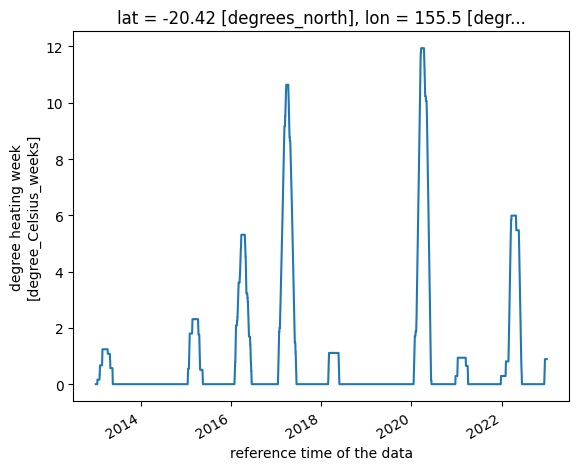

In [19]:
data.degree_heating_week.plot()

## Delete the temp zip file

In [20]:
os.remove(zip_path)